# analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error


# load dataset

In [2]:
df = pd.read_csv("bangalore.csv")
df.head()


,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


# cleaning

In [3]:
# Extract bhk
df['bhk'] = df['size'].str.extract(r'(\d+)').astype(float)

# Convert total_sqft
def convert_sqft(x):
    try:
        if '-' in str(x):
            a, b = x.split('-')
            return (float(a) + float(b)) / 2
        return float(x)
    except:
        return None

df['total_sqft'] = df['total_sqft'].apply(convert_sqft)
df['total_sqft'] = pd.to_numeric(df['total_sqft'], errors='coerce')

# Drop NaN rows
df.dropna(subset=['total_sqft', 'bath', 'price', 'bhk'], inplace=True)

# Convert price to INR
df['price_inr'] = df['price'] * 1e5


In [4]:
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,bhk,price_inr
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056.0,2.0,1.0,39.07,2.0,3907000.0
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600.0,5.0,3.0,120.00,4.0,12000000.0
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440.0,2.0,3.0,62.00,3.0,6200000.0
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521.0,3.0,1.0,95.00,3.0,9500000.0
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200.0,2.0,1.0,51.00,2.0,5100000.0


# feature engineering

In [5]:
# Add price per sqft
df['price_per_sqft'] = df['price_inr'] / df['total_sqft']

# Remove outliers in price_per_sqft
mean = df['price_per_sqft'].mean()
std = df['price_per_sqft'].std()
df = df[(df['price_per_sqft'] > mean - 2*std) & (df['price_per_sqft'] < mean + 2*std)]


# handle categorical location

In [7]:
df['location'] = df['location'].astype(str).str.strip()
location_counts = df['location'].value_counts()
df['location'] = df['location'].apply(lambda x: x if location_counts.get(x, 0) > 10 else 'Other')


In [8]:
location_dummies = pd.get_dummies(df['location'], drop_first=True)

X = pd.concat([df[['total_sqft', 'bath', 'bhk', 'price_per_sqft']], location_dummies], axis=1)
y = df['price_inr']


# train-test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# linear regression

In [10]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)


In [11]:
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("R² Score:", r2)
print("RMSE:", rmse)


R² Score: 0.6476222843247175
RMSE: 8940911.640579117


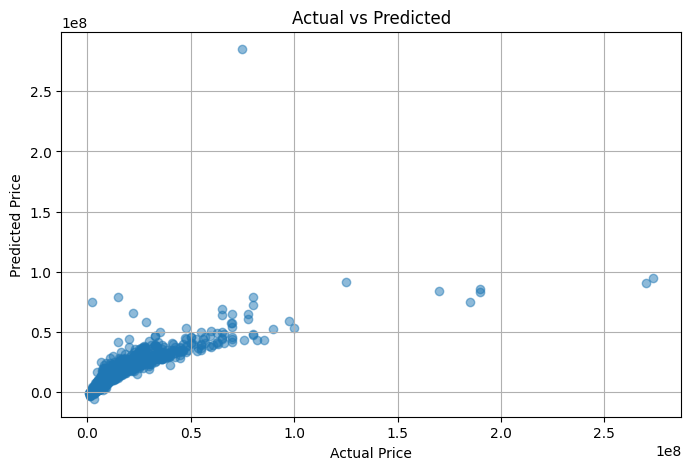

In [12]:
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted")
plt.grid(True)
plt.show()
